1. Understand the problem and read in the data
2. Pre-process data, train-test split
3. Build and compile a deep learning model

# Black_Friday

In [6]:
'''Import necessary packages'''
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd 
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [7]:
%pwd

'C:\\Users\\forhj\\Desktop\\6105'

In [8]:
path = "C:\\Users\\forhj\\Desktop\\6105"

In [9]:
df = pd.read_csv(f'{path}/BlackFriday.csv',header = None)
print(df.shape)
df.head(2)

(537578, 12)


C:\Users\forhj\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,4,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11
0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370


In [10]:
my_df=df.rename(columns=df.iloc[0]).drop(df.index[0])
my_df.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
2,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200


In [11]:
my_df.shape

(537577, 12)

#### Check for null values in the columns as first step to preprocess data

In [12]:
my_df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

#### Plot missing values

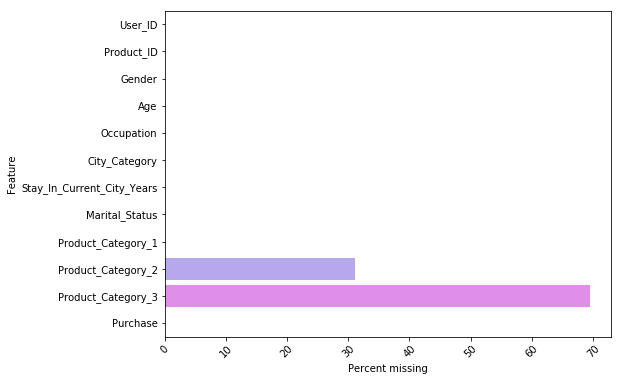

In [13]:
null_vals = my_df.isnull().sum()/len(my_df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(y = "Feature",x ="Percent missing",orient='h',data=null_vals)

#### Although there are lot of missing values for product_category2 and product_category3, let's retain them as these might be important for the analysis

In [14]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537577 entries, 1 to 537577
Data columns (total 12 columns):
User_ID                       537577 non-null object
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null object
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null object
Product_Category_1            537577 non-null object
Product_Category_2            370591 non-null object
Product_Category_3            164278 non-null object
Purchase                      537577 non-null object
dtypes: object(12)
memory usage: 53.3+ MB


In [15]:
#Define a function to convert object types and string types to category type
def str_to_cat(my_df):
    for p,q in my_df.items(): 
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df 

In [16]:
my_df2 = str_to_cat(my_df)
my_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537577 entries, 1 to 537577
Data columns (total 12 columns):
User_ID                       537577 non-null category
Product_ID                    537577 non-null category
Gender                        537577 non-null category
Age                           537577 non-null category
Occupation                    537577 non-null category
City_Category                 537577 non-null category
Stay_In_Current_City_Years    537577 non-null category
Marital_Status                537577 non-null category
Product_Category_1            537577 non-null category
Product_Category_2            370591 non-null category
Product_Category_3            164278 non-null category
Purchase                      537577 non-null category
dtypes: category(12)
memory usage: 13.9 MB


In [17]:
my_df2.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
2,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200
3,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


#### There are no missing features, so we do not have to drop any columns

In [18]:
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table): 
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [19]:
my_df3,my_table = mydf_preprocessor(my_df2,null_table = None)

In [20]:
my_df3.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,5892,671,1,1,24,1,3,3,30,0,0,29333
2,5892,2375,1,1,24,1,3,3,19,31,20,20644
3,5892,851,1,1,24,1,3,3,22,0,0,20427


In [21]:
my_df3.isnull().sum().sum()

0

In [22]:
#Separate out X and Y
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
X = my_df3.iloc[:, :11]
Y = my_df3.iloc[:, 11:12]

#X["Purchase"]

#### (a) scaling/standardizing all columns

In [23]:
scaler = preprocessing.StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
print(X.shape)

(537577, 11)


C:\Users\forhj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\forhj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by StandardScaler.
  


#### (b)	Split the entire dataset into three parts instead of two as we currently do. One is train, two is validation, and then a test set. Build DNN model with train data, tune hyper-parameters with validation data, and finally evaluate performance on the test data.

In [24]:
# First split the dataset into Training set and Test set. Training set below is train_valid
(X_train_valid,X_test,Y_train_valid,Y_test) = train_test_split(X, Y, test_size=0.15, random_state=1)
print(X_train_valid.shape,X_test.shape,Y_train_valid.shape,Y_test.shape)

(456940, 11) (80637, 11) (456940, 1) (80637, 1)


In [25]:
# Second, split the training set into train and validation set
(X_train,X_valid,Y_train,Y_valid) = train_test_split(X_train_valid, Y_train_valid, test_size=0.15, random_state=1)
print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(388399, 11) (68541, 11) (388399, 1) (68541, 1)


In [26]:
# Build the deep neural network
model = Sequential()
model.add(Dense(18, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(6, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform'))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# Compile the DNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the DNN with your train data
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=4, batch_size=50)

Instructions for updating:
Use tf.cast instead.
Train on 388399 samples, validate on 68541 samples
Epoch 1/4
388399/388399 [==============================] - 7s 17us/step - loss: -144619.5957 - acc: 7.7240e-06 - val_loss: -148665.7508 - val_acc: 0.0000e+00
Epoch 2/4
388399/388399 [==============================] - 7s 18us/step - loss: -149420.6455 - acc: 7.7240e-06 - val_loss: -148665.7508 - val_acc: 0.0000e+00
Epoch 3/4
268800/388399 [===================>..........] - ETA: 2s - loss: -149423.4786 - acc: 7.4405e-06


#### Tuning hyperparameters with validation set, building model with training set and evaluating performance on test set

In [ ]:
scores = model.evaluate(X_valid, Y_valid)
print ("Accuracy: %.2f%%" %(scores[1]*100))

In [ ]:
scores = model.evaluate(X_test, Y_test)
print ("Accuracy: %.2f%%" %(scores[1]*100))

### 1.c. Make Epoch versus train set accuracy, and validation set accuracy

In [ ]:
history = model.fit(X_train, Y_train,
                    nb_epoch=100, batch_size=5,
                    verbose=0,
                    validation_data=(X_valid, Y_valid))

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.show()

### 1.d. Report results using nice ROC curves, report AUC values

In [ ]:
y_pred=model.predict(X_valid)
y_pred_test=model.predict(X_test)

#### Reporting AUC values for both test and validation set:

In [ ]:
print("AUC for Validation:",roc_auc_score(Y_valid,y_pred))
print("AUC for Test Set:",roc_auc_score(Y_test,y_pred_test))

#### ROC curves for both test and validation set:

In [ ]:
FP, TP, thresholds = roc_curve(Y_valid,y_pred)
plt.plot(FP, TP)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
FP, TP, thresholds = roc_curve(Y_test,y_pred_test)
plt.plot(FP, TP)
plt.title('ROC curve for test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')